In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
df = pd.read_csv('AirPassengers.csv')

In [3]:
df.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [4]:
df.shape

(144, 2)

In [5]:
from datetime import datetime as dt

In [6]:
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima_model import ARIMA
import math
from matplotlib.pylab import rcParams
rcParams['figure.figsize']=15,6

In [7]:
data = df
# Apply Lambda function to read first 4 characters as year, last 2 characters as month, and 15 as day 
# This will allow to index by month. 
data['Month']=data['Month'].apply(lambda x:dt(int(x[:4]), int(x[5:]), 15))

In [8]:
data=data.set_index('Month')
data.head()

,#Passengers
Month,
1949-01-15,112
1949-02-15,118
1949-03-15,132
1949-04-15,129
1949-05-15,121


In [9]:
ts = data['#Passengers']

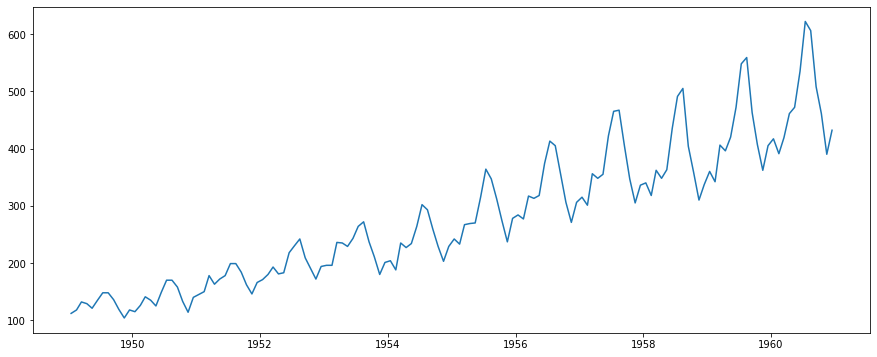

In [10]:
plt.plot(ts)

In [11]:
ts_log=np.log(ts)

In [12]:
# STationarity check
def test_stationarity(timeseries):
    rollmean=timeseries.rolling(window=52, center=False).mean()
    rollstd= timeseries.rolling(window=52, center=False).std()
    
    orig=plt.plot(timeseries, color='blue', label='Original')
    mean=plt.plot(rollmean,  color='red', label='Rolling Mean')
    std= plt.plot(rollstd, color = 'black', label='Rolling Std')
    
    plt.legend(loc='best')
    plt.title('Rolling Mean & STandard Deviation')
    plt.show(block=False)
    
    print('Result of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput=pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used',
                                          'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key]=value
    print(dfoutput)

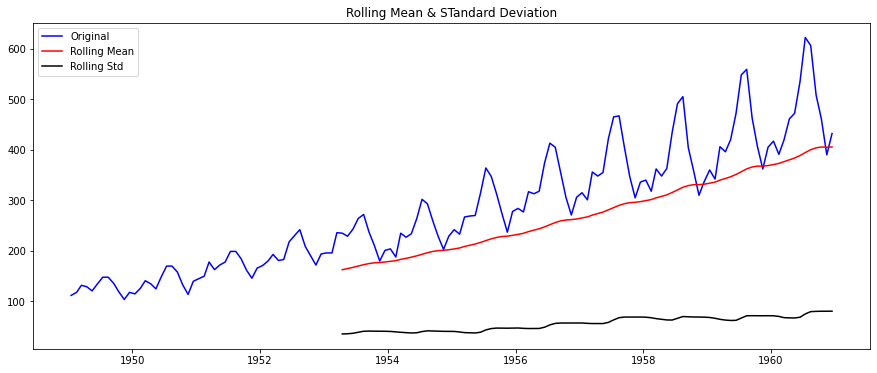

Result of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [13]:
test_stationarity(data['#Passengers'])

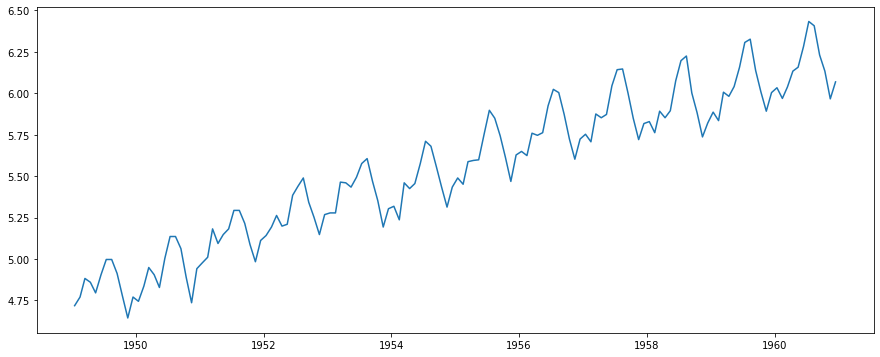

In [14]:
plt.plot(ts_log)

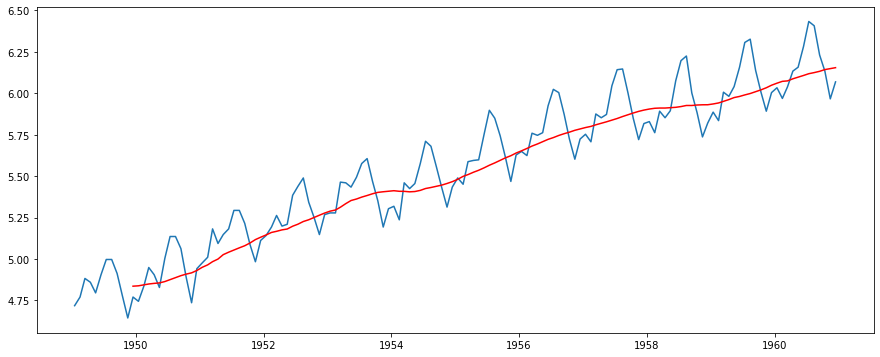

In [15]:
movingAverage=ts_log.rolling(window=12).mean()
movingSTD= ts_log.rolling(window=12).std()
plt.plot(ts_log)
plt.plot(movingAverage, color='red')

In [16]:
ts_log_mv_diff = ts_log - movingAverage
ts_log_mv_diff.head(12)

Month
1949-01-15         NaN
1949-02-15         NaN
1949-03-15         NaN
1949-04-15         NaN
1949-05-15         NaN
1949-06-15         NaN
1949-07-15         NaN
1949-08-15         NaN
1949-09-15         NaN
1949-10-15         NaN
1949-11-15         NaN
1949-12-15   -0.065494
Name: #Passengers, dtype: float64

In [17]:
ts_log_mv_diff.dropna(inplace=True)
ts_log_mv_diff.head(10)

Month
1949-12-15   -0.065494
1950-01-15   -0.093449
1950-02-15   -0.007566
1950-03-15    0.099416
1950-04-15    0.052142
1950-05-15   -0.027529
1950-06-15    0.139881
1950-07-15    0.260184
1950-08-15    0.248635
1950-09-15    0.162937
Name: #Passengers, dtype: float64

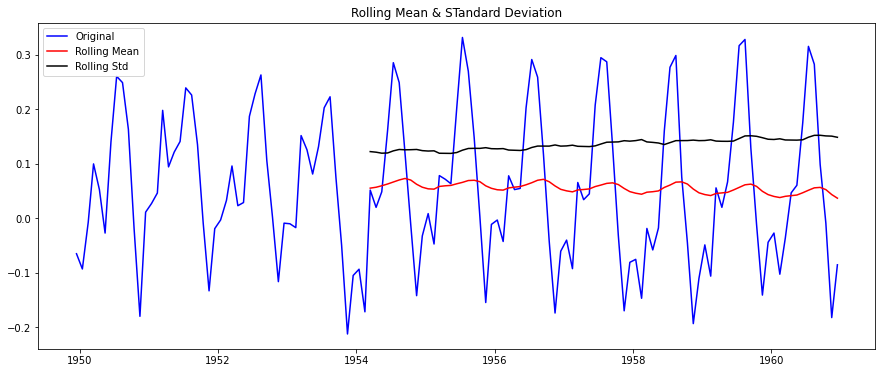

Result of Dickey-Fuller Test:
Test Statistic                  -3.162908
p-value                          0.022235
#Lags Used                      13.000000
Number of Observations Used    119.000000
Critical Value (1%)             -3.486535
Critical Value (5%)             -2.886151
Critical Value (10%)            -2.579896
dtype: float64


In [19]:
test_stationarity(ts_log_mv_diff)

/usr/local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:572: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning


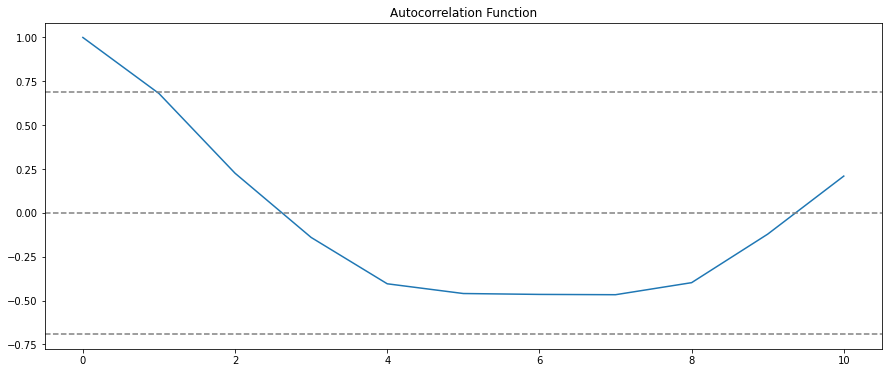

In [20]:
plt.plot(np.arange(0,11), acf(ts_log_mv_diff, nlags=10))
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-7.96/np.sqrt(len(ts_log_mv_diff)), linestyle='--', color='gray')
plt.axhline(y=7.96/np.sqrt(len(ts_log_mv_diff)), linestyle='--', color='gray')
plt.title('Autocorrelation Function')
plt.show()

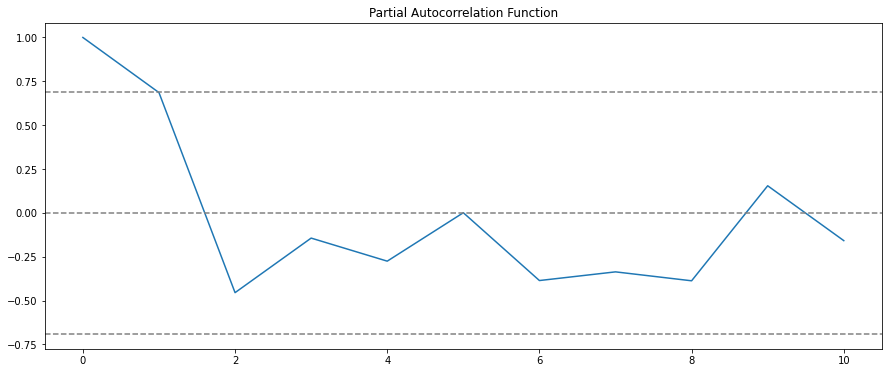

In [21]:
plt.plot(np.arange(0,11), pacf(ts_log_mv_diff, nlags=10))
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-7.96/np.sqrt(len(ts_log_mv_diff)), linestyle='--', color='gray')
plt.axhline(y=7.96/np.sqrt(len(ts_log_mv_diff)), linestyle='--', color='gray')
plt.title('Partial Autocorrelation Function')
plt.show()

/usr/local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


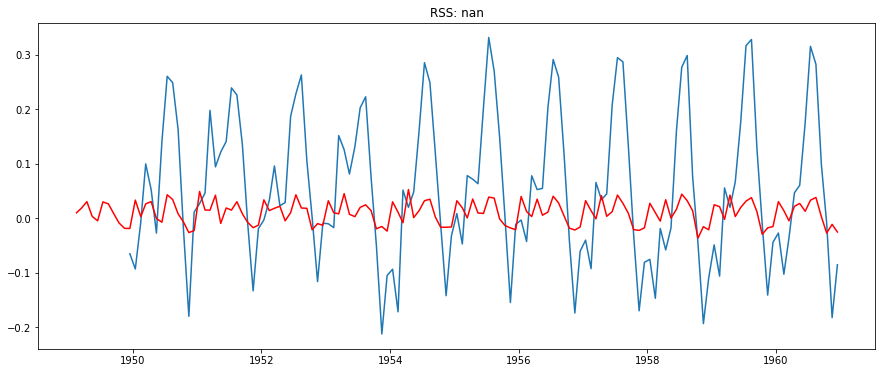

In [23]:
model=ARIMA(ts_log, order=(1,1,0))
results_ARIMA = model.fit(disp=-1)
plt.plot(ts_log_mv_diff)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues[1:] - ts_log_mv_diff)**2))
plt.show()

In [24]:
prediction_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
prediction_ARIMA_diff.head()

Month
1949-02-15    0.009676
1949-03-15    0.018164
1949-04-15    0.030130
1949-05-15    0.003154
1949-06-15   -0.005039
dtype: float64

In [29]:
prediction_ARIMA_diff_cumsum = prediction_ARIMA_diff.cumsum()
prediction_ARIMA_diff_cumsum.head()

Month
1949-02-15    0.009676
1949-03-15    0.027839
1949-04-15    0.057969
1949-05-15    0.061123
1949-06-15    0.056084
dtype: float64

In [31]:
prediction_ARIMA_log = pd.Series(ts_log.iloc[0], index=ts_log.index)
prediction_ARIMA_log = prediction_ARIMA_log.add(prediction_ARIMA_diff_cumsum, fill_value=0)
prediction_ARIMA_log.head()

Month
1949-01-15    4.718499
1949-02-15    4.728175
1949-03-15    4.746338
1949-04-15    4.776468
1949-05-15    4.779622
dtype: float64

Text(0.5, 1.0, 'RMSE: 52.1841')

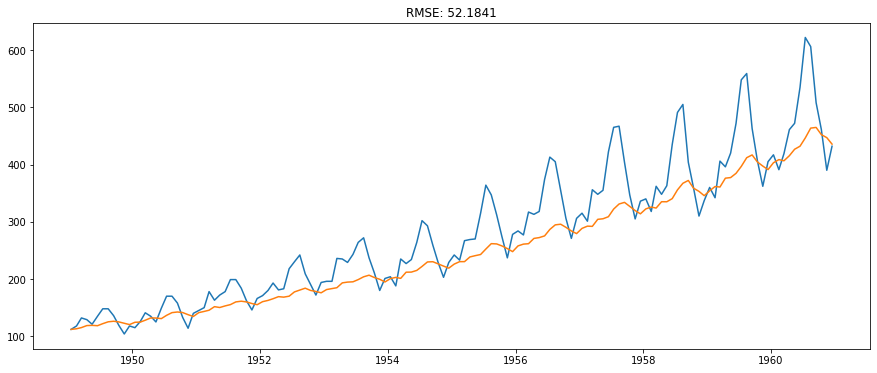

In [33]:
prediction_ARIMA = np.exp(prediction_ARIMA_log)
plt.plot(ts)
plt.plot(prediction_ARIMA)
plt.title('RMSE: %.4f'% np.sqrt(sum((prediction_ARIMA - ts)**2)/len(ts)))